# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from geopy.distance import geodesic, GeodesicDistance
import xgboost as xgb
import math
kfolds = 5
random_seed = 33
pd.set_option('display.max_columns',None)

# **Investigating Data**

In [4]:
# Importing data
df = pd.read_csv('../datasets/train.csv')


In [ ]:
encoded_df = pd.get_dummies(df, columns=['day'], drop_first=True)


In [41]:
# checking how many features/records you are dealing with
df.shape

(1000000, 10)

In [42]:
# see some examples of data to  know some feature
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967


In [44]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')

## Column Details


Id: A unique identifier for each trip

Vendor Id: A unique identifier for vendor

Pickup Datetime: Date and time of pickup

Dropoff Datetime: Date and time of dropoff

Passenger Count: The number of passengers in the vehicle (driver entered value)

Pickup Longitude: The longitude where the meter was engaged

Pickup Latitude: The latitude where the meter was engaged

Dropoff Longitude: The longitude where the meter was disengaged

Dropoff Latitude: The latitude where the meter was disengaged

Store and Fwd Flag: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.

Trip Duration: Duration of time in seconds

In [45]:
# Check the data type of features to know if we will transform any thing.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1000000 non-null  object 
 1   vendor_id           1000000 non-null  int64  
 2   pickup_datetime     1000000 non-null  object 
 3   passenger_count     1000000 non-null  int64  
 4   pickup_longitude    1000000 non-null  float64
 5   pickup_latitude     1000000 non-null  float64
 6   dropoff_longitude   1000000 non-null  float64
 7   dropoff_latitude    1000000 non-null  float64
 8   store_and_fwd_flag  1000000 non-null  object 
 9   trip_duration       1000000 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 76.3+ MB


## Numerical Values

1   vendor_id           1000000 non-null  int64

3   passenger_count     1000000 non-null  int64  

4   pickup_longitude    1000000 non-null  float64

5   pickup_latitude     1000000 non-null  float64

6   dropoff_longitude   1000000 non-null  float64

7   dropoff_latitude    1000000 non-null  float64

In [46]:
# see statistics about numerical features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,1000000.0,1.534793,0.498788,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1000000.0,1.665353,1.315723,0.000000,1.000000,1.000000,2.000000,7.000000e+00
pickup_longitude,1000000.0,-73.973475,0.065404,-121.933342,-73.991852,-73.981728,-73.967346,-6.133553e+01
pickup_latitude,1000000.0,40.750947,0.033745,34.359695,40.737372,40.754131,40.768379,5.188108e+01
dropoff_longitude,1000000.0,-73.973421,0.065432,-121.933304,-73.991341,-73.979767,-73.963036,-6.133553e+01
dropoff_latitude,1000000.0,40.751829,0.035782,34.359695,40.735928,40.754551,40.769833,4.392103e+01
trip_duration,1000000.0,954.884971,3882.070116,1.000000,397.000000,662.000000,1074.000000,2.227612e+06


In [47]:
# See Statistics about categorical features
df.describe(include='O').T

,count,unique,top,freq
id,1000000,1000000,id2793718,1
pickup_datetime,1000000,962731,2016-04-05 18:55:21,5
store_and_fwd_flag,1000000,2,N,994443


## first before start analysis you must check for missing values and duplicates


In [48]:
df.isnull().sum() # fortunately our data has no missing data:)

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [49]:
df.duplicated().sum() # No duplicated rows :)

0

# **EDA**


### let's explore the numerical features  
### but first we should transfor some features (as we saw earlier)
### like date and we should create distance feature
### we must create check point to differentiate between the original data and the data that we will work on
### We noticed a timestamp feature so will tranform it to : year, month, day, hour

In [12]:
#Tranforming pickup_datetime to date
df_eda = df.copy()  # copied the data in new block in memory  the data a (check point)
df_eda['pickup_datetime'] = pd.to_datetime(df_eda['pickup_datetime'])
df_eda['year'] = df_eda['pickup_datetime'].dt.year
df_eda['month'] = df_eda['pickup_datetime'].dt.month
df_eda['day'] = df_eda['pickup_datetime'].dt.day_name()
df_eda['hour'] = df_eda['pickup_datetime'].dt.hour

In [13]:
encoded_df = pd.get_dummies(df_eda, columns=['day'], drop_first=True, sparse=True, dtype=int)


In [14]:
encoded_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,hour,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040,2016,6,7,0,0,0,0,0,1
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827,2016,4,12,0,0,1,0,0,0
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614,2016,6,2,0,0,1,0,0,0
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867,2016,5,17,0,0,0,1,0,0
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967,2016,5,17,0,0,0,1,0,0


## There are also coordinates feature of latitude and longitude for pickup and dropoff location we can get the distance of the trip

In [51]:
distance = []
for index in df_eda['pickup_latitude'].index :
    distance.append(geodesic((df_eda['pickup_latitude'].iloc[index],df_eda['pickup_longitude'].iloc[index]),(df_eda['dropoff_latitude'].iloc[index],df_eda['dropoff_longitude'].iloc[index])).miles)
df_eda['distance'] = distance

In [13]:
df_eda.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,day,hour,distance
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040,2016,6,Wednesday,7,1.714799
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827,2016,4,Sunday,12,1.217305
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614,2016,6,Sunday,2,0.874721
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867,2016,5,Thursday,17,1.227875
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967,2016,5,Thursday,17,12.962925


## Let's start to analyze the numerical features
## We will see the distribution of each one


In [14]:
numerical = df_eda.select_dtypes(include = 'number').columns.tolist()
numerical

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'trip_duration',
 'year',
 'month',
 'hour',
 'distance']

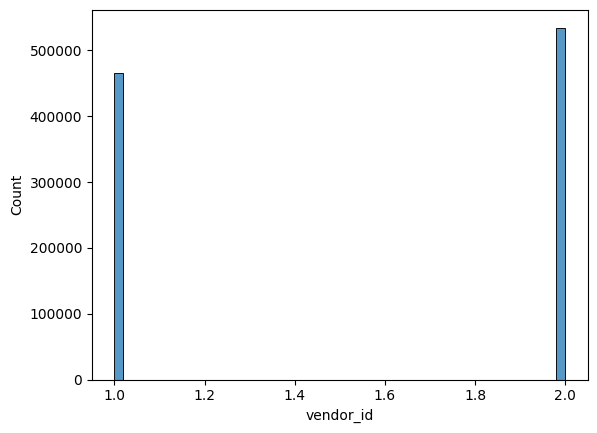

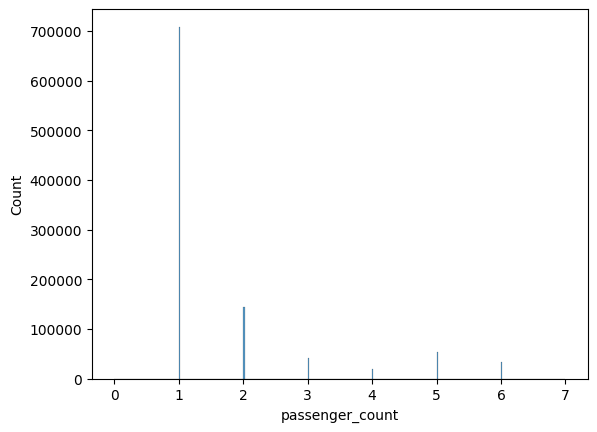

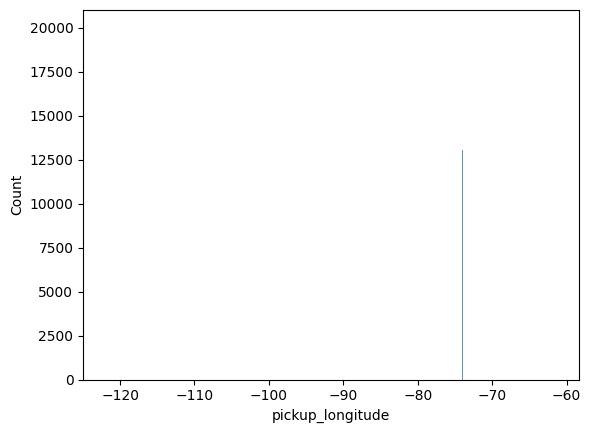

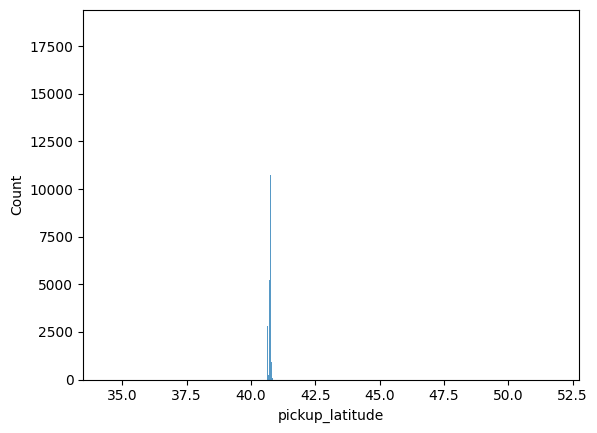

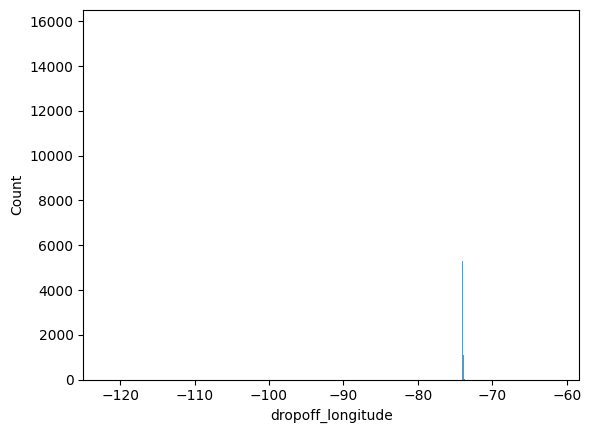

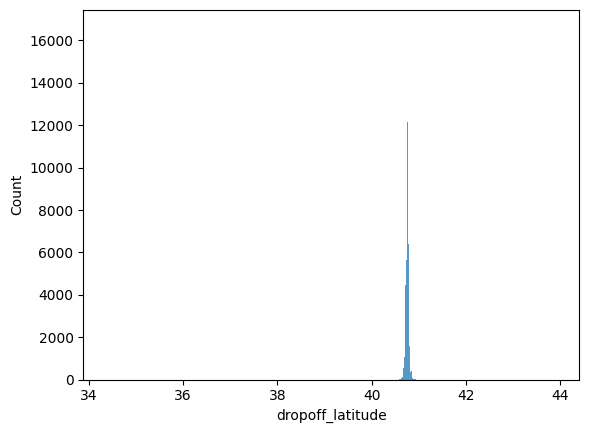

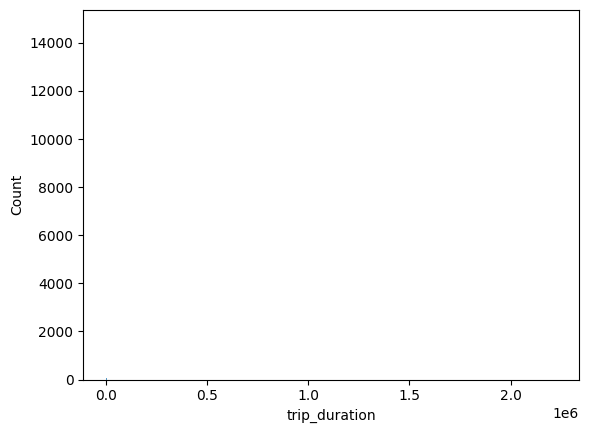

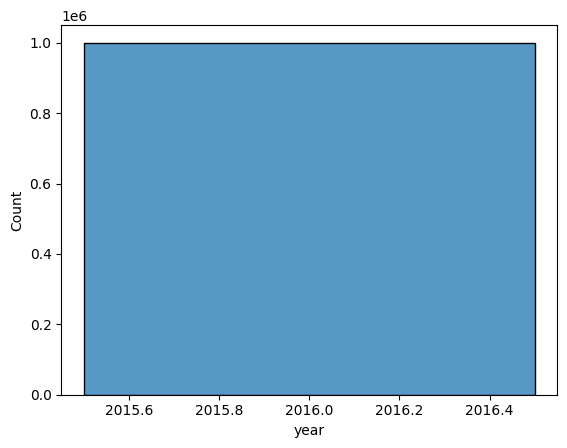

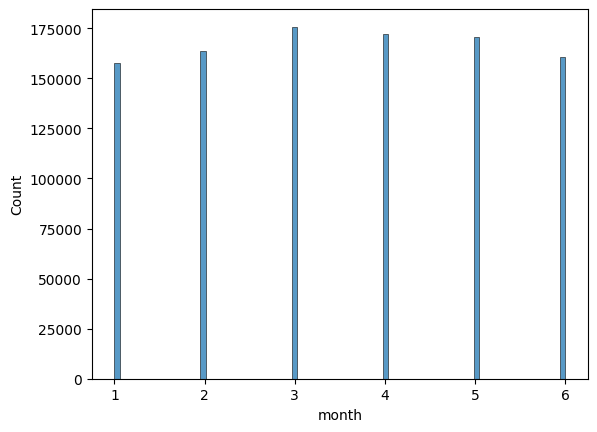

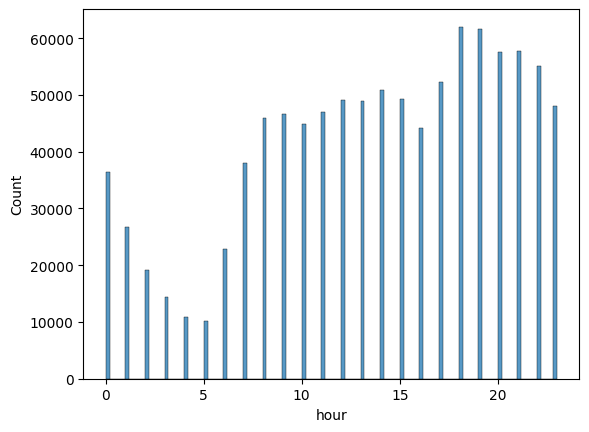

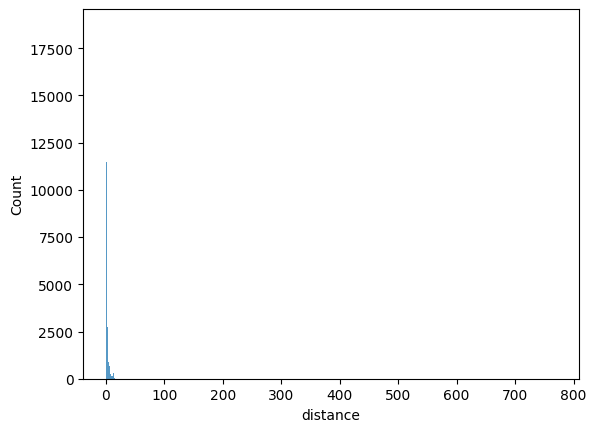

In [15]:
for i in numerical:
    sns.histplot(df_eda[i])
    plt.xlabel(i)
    plt.show()

## The distance and duration are the most important but we can't get any information from this distribution so we will do log transformation

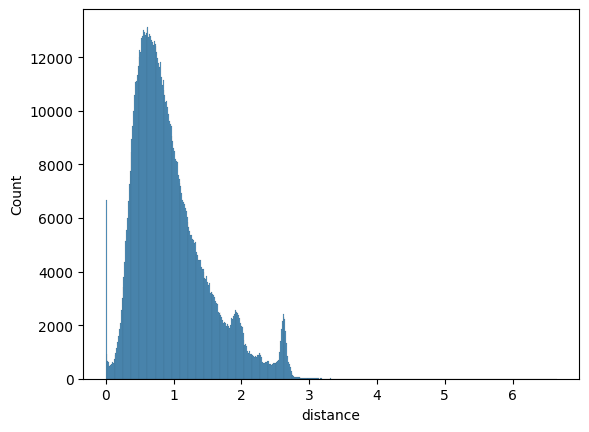

In [16]:
sns.histplot(np.log1p(df_eda['distance'])) ##
plt.show()
# a little skewwed with outliers

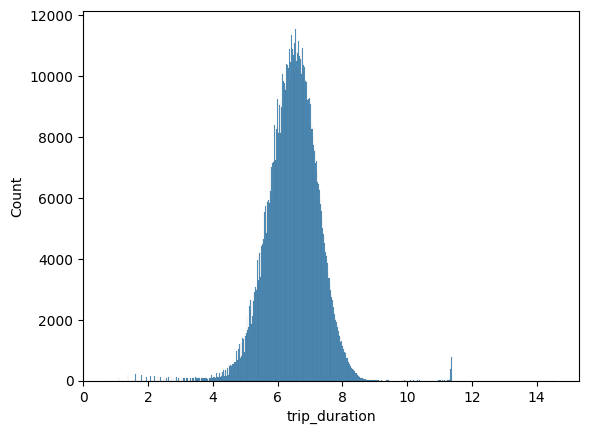

In [17]:
sns.histplot(np.log1p(df_eda['trip_duration']))
plt.show()
# kinda symmetric but still there are some outliers as well

## We observe that the  distance distribution is left skewed which means most of the trips are kinda short distance and the mean is smaller than the median
## duration is kinda symmetric which is normal

## Let's the Box plot to check outliers

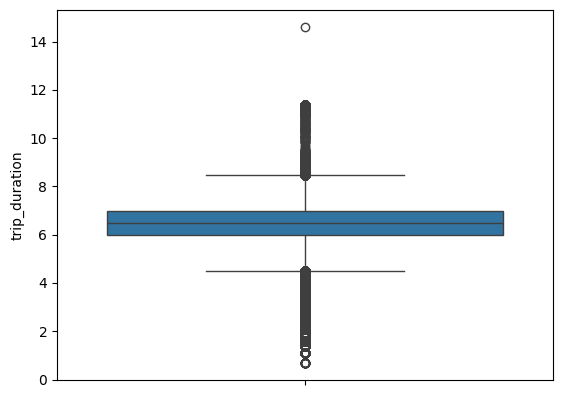

In [18]:
sns.boxplot(np.log1p(df_eda['trip_duration']))
plt.show()

### alot of outliers :)

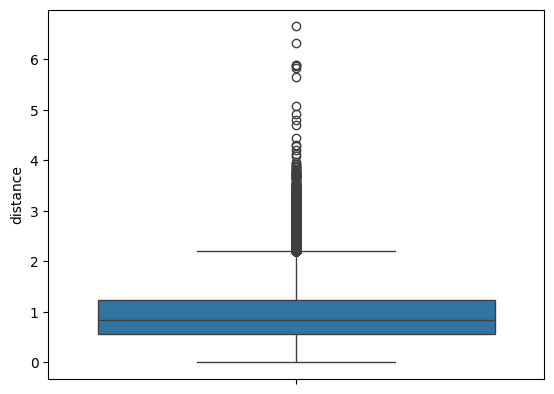

In [19]:
sns.boxplot(np.log1p(df_eda['distance']))
plt.show()
##same outliers

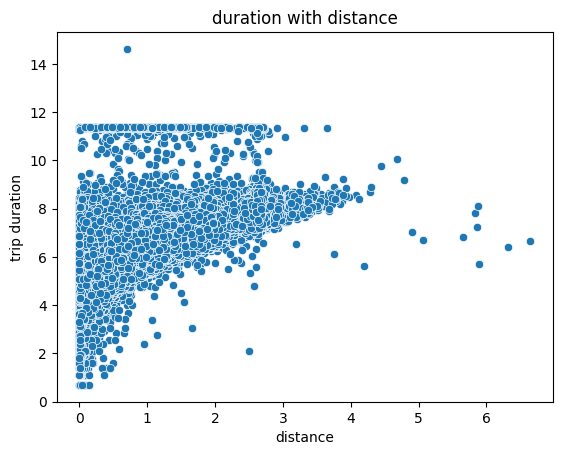

In [20]:
sns.scatterplot(x = np.log1p(df_eda['distance']),y = np.log1p(df_eda['trip_duration']))
plt.xlabel('distance')
plt.ylabel('trip duration')
plt.title('duration with distance')
plt.show()

## practically by increasing the distance the time should increase
## but we see some examples like it's not even normal in any way


## To go further Let's create speed feature (in miles per hour)

In [52]:
df_eda['speed_mph'] = df_eda['distance']/((df_eda['trip_duration']) /3600)

### Let's see the outliers with speed feature

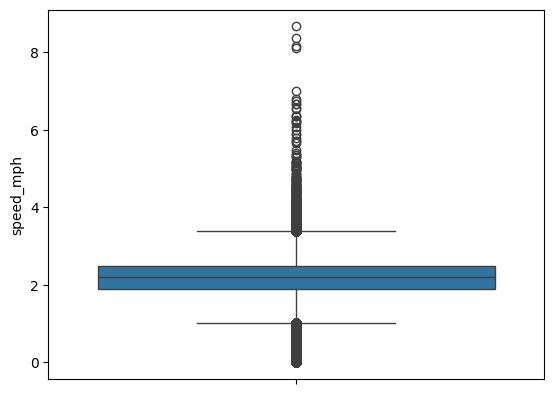

In [22]:
sns.boxplot(np.log1p(df_eda['speed_mph']))
plt.show()

## Let's do further analysis on discrete numerical features to get more insights

In [23]:
numerical = df_eda.select_dtypes(include = 'number').columns.tolist()
numerical

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'trip_duration',
 'year',
 'month',
 'hour',
 'distance',
 'speed_mph']

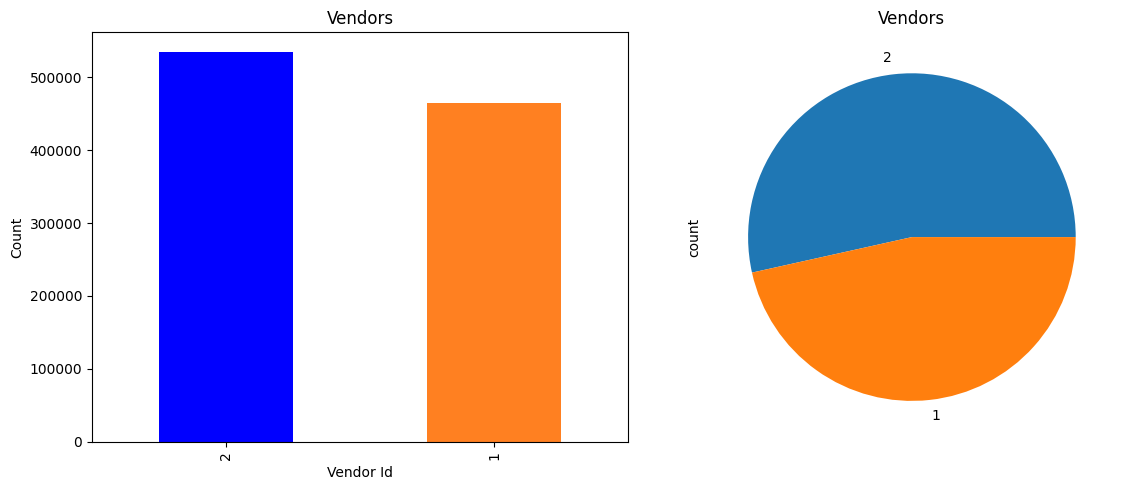

In [24]:
## see some bar chart and pie chart of vendor id
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
ax = df_eda['vendor_id'].value_counts().plot(kind='bar',title="Vendors",ax=axes[0],color = ('blue',(1, 0.5, 0.13)))
df_eda['vendor_id'].value_counts().plot(kind='pie',title="Vendors",ax=axes[1])
ax.set_ylabel("Count")
ax.set_xlabel("Vendor Id")
fig.tight_layout()

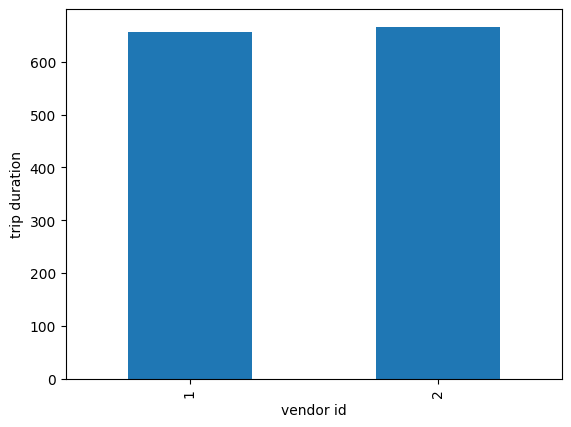

In [25]:
df_eda.groupby('vendor_id')['trip_duration'].median().plot.bar()
plt.xlabel('vendor id')
plt.ylabel('trip duration')
plt.show()

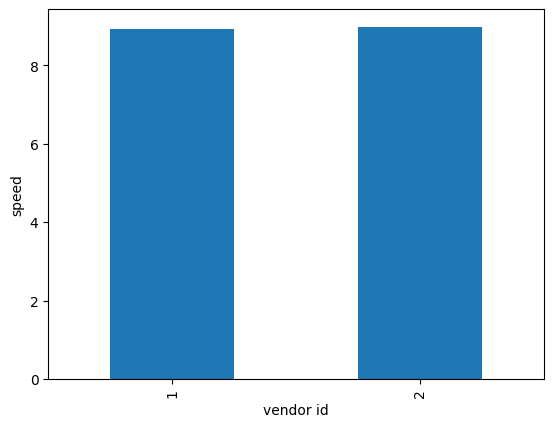

In [26]:
df_eda.groupby('vendor_id')['speed_mph'].mean().plot.bar()
plt.xlabel('vendor id')
plt.ylabel('speed')
plt.show()

## Almost same according to median value of trip duration and same avg speed
## Vendor 2 takes the Crown.

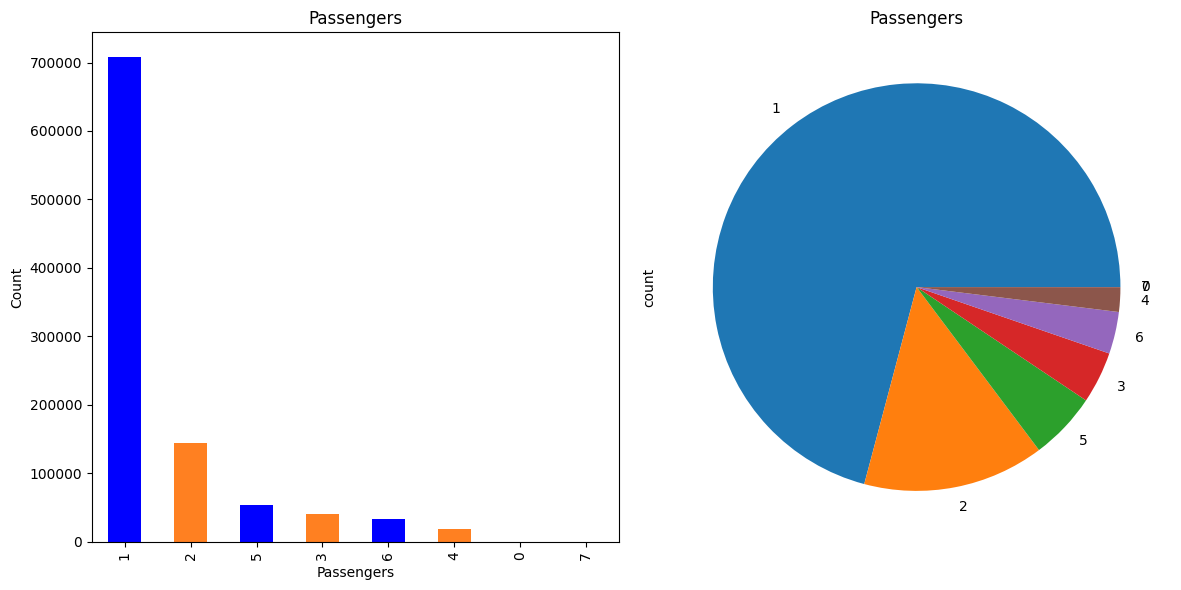

In [27]:
## see some bar chart and pie chart of passenger counts
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
ax = df_eda['passenger_count'].value_counts().plot(kind='bar',title="Passengers",ax=axes[0],color = ('blue',(1, 0.5, 0.13)))
df_eda['passenger_count'].value_counts().plot(kind='pie',title="Passengers",ax=axes[1])
ax.set_ylabel("Count")
ax.set_xlabel("Passengers")
fig.tight_layout()

## We observe most of the time it's just one passenger in the trip

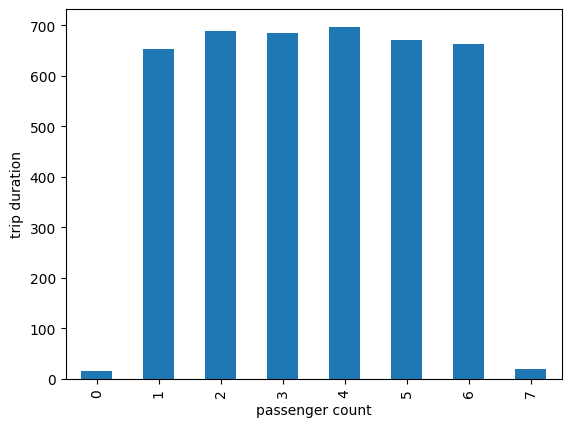

In [28]:
df_eda.groupby('passenger_count')['trip_duration'].median().plot.bar()
plt.xlabel('passenger count')
plt.ylabel('trip duration')
plt.show()

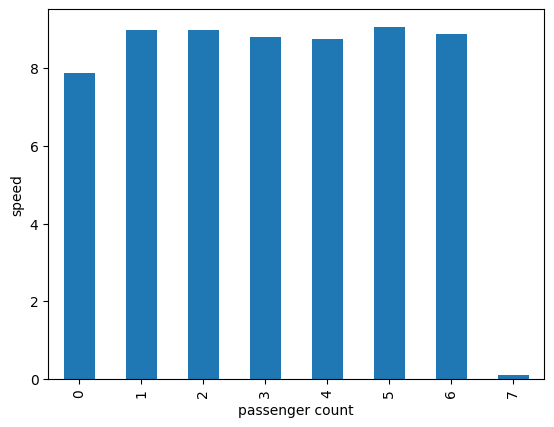

In [29]:
df_eda.groupby('passenger_count')['speed_mph'].mean().plot.bar()
plt.xlabel('passenger count')
plt.ylabel('speed')
plt.show()

## We see more passengers doesn't affect the speed or time duration of the trip that much

<Axes: xlabel='month'>

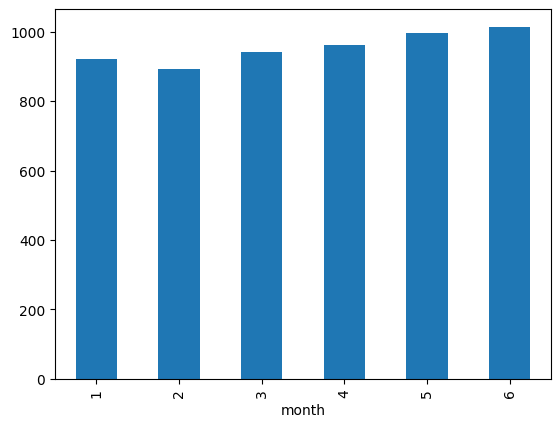

In [30]:
df_eda.groupby('month')['trip_duration'].mean().plot.bar()


<Axes: xlabel='month'>

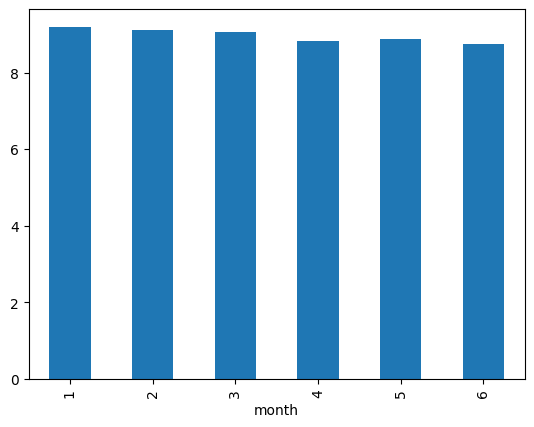

In [31]:
df_eda.groupby('month')['speed_mph'].mean().plot.bar()

### The duration incresases slightly in the 2nd quarter of the year same as avg speed is slightly decreasing in 2nd quarter of the year

Text(0, 0.5, 'trip_duration')

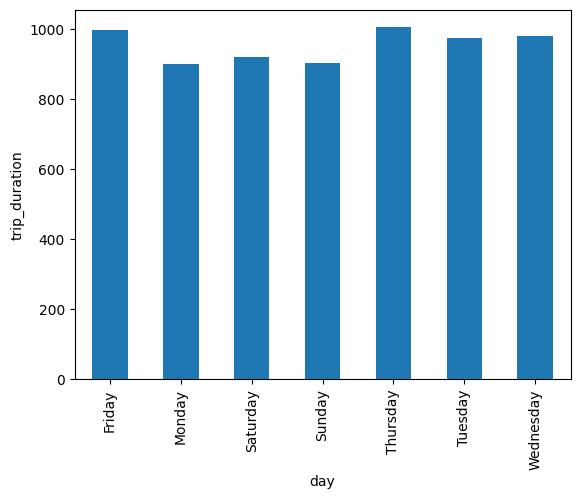

In [32]:
## let's see the day of the week
df_eda.groupby('day')['trip_duration'].mean().plot.bar()
plt.xlabel('day')
plt.ylabel('trip_duration')

Text(0, 0.5, 'speed')

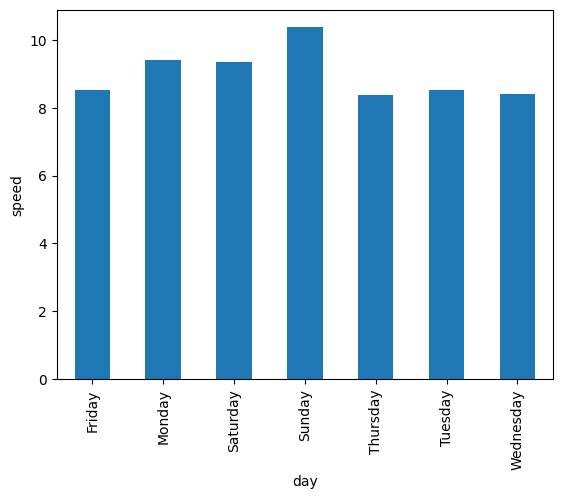

In [33]:
df_eda.groupby('day')['speed_mph'].mean().plot.bar()
plt.xlabel('day')
plt.ylabel('speed')

## We see from Tuesday to friday the duration increases especially in Thurusday and Friday also as at Sunday the maximum avg speed and the less trip durations

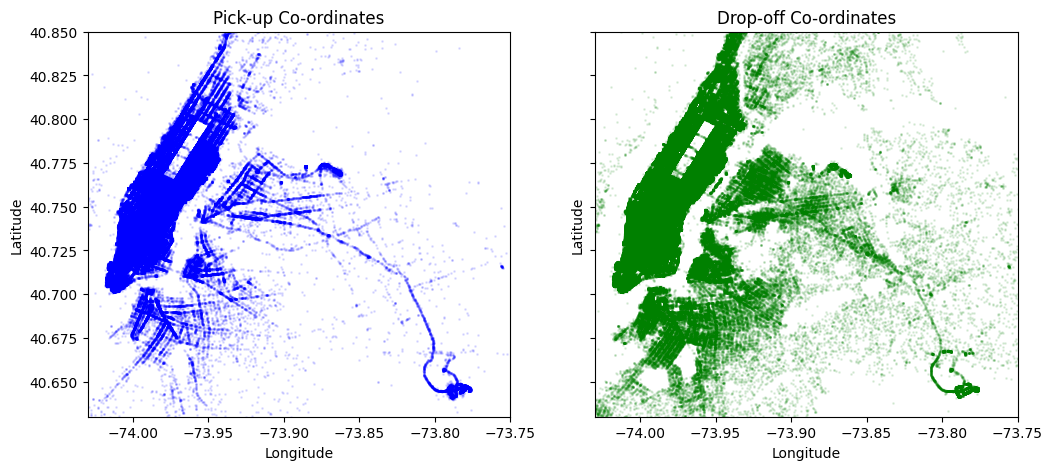

In [34]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,figsize = (12,5))
ax[0].scatter(df_eda['pickup_longitude'].values, df_eda['pickup_latitude'].values,
color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(df_eda['dropoff_longitude'].values, df_eda['dropoff_latitude'].values,
color='green', s=1, label='train', alpha=0.1)
ax[1].set_title('Drop-off Co-ordinates')
ax[0].set_title('Pick-up Co-ordinates')
ax[0].set_ylabel('Latitude')
ax[0].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

### for some locations both from latitude 40.700 to 40.825 we see in both pick-up locations and drop-off locations are positioned in these co-ordinates which gives us that these locations will be crowded somehow, also in the drop-off we see the data are kinda distributed among more co-ordinates not like the pick-up locations.

## We can also calcuate bearing (direction) between any two latitudes and longitudes


In [53]:
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Difference in longitude
    delta_lon = lon2_rad - lon1_rad
    
    # Apply the Haversine formula
    y = math.sin(delta_lon) * math.cos(lat2_rad)
    x = math.cos(lat1_rad) * math.sin(lat2_rad) - \
        math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon)
    
    # Calculate the initial bearing
    theta = math.atan2(y, x)
    
    # Convert to degrees and ensure it's between 0° and 360°
    bearing = math.degrees(theta)
    if bearing < 0:
        bearing += 360
    
    return bearing

    
    


In [54]:
bearings = []
for _, row in df_eda.iterrows():
    bearing = calculate_bearing(
        row['pickup_latitude'],
        row['pickup_longitude'],
        row['dropoff_latitude'],
        row['dropoff_longitude']
    )
    bearings.append(bearing)

df_eda['bearing'] = bearings

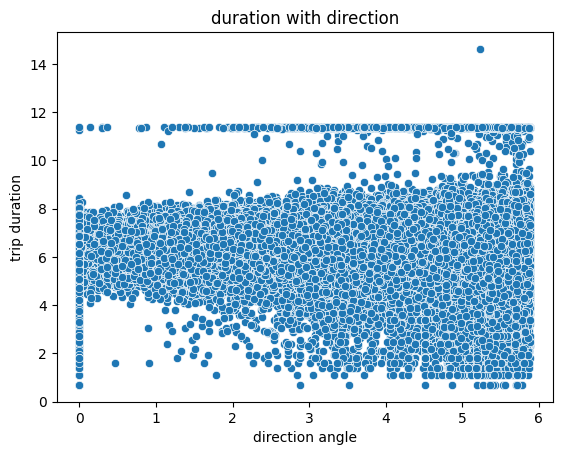

In [37]:
sns.scatterplot(x = np.log1p(df_eda['bearing']),y = np.log1p(df_eda['trip_duration']))
plt.xlabel('direction angle')
plt.ylabel('trip duration')
plt.title('duration with direction')
plt.show()

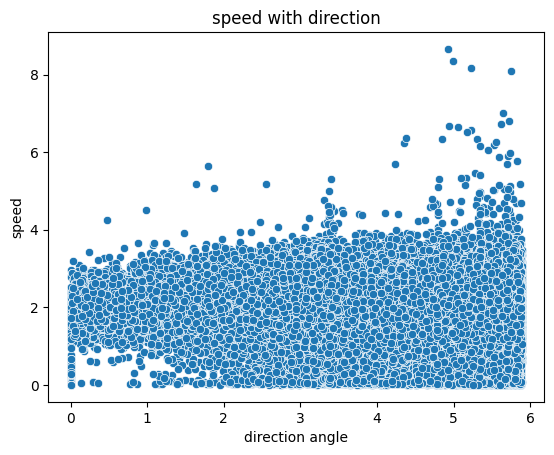

In [38]:
sns.scatterplot(x = np.log1p(df_eda['bearing']),y = np.log1p(df_eda['speed_mph']))
plt.xlabel('direction angle')
plt.ylabel('speed')
plt.title('speed with direction')
plt.show()

### we direction of the trip does not effect the duration 

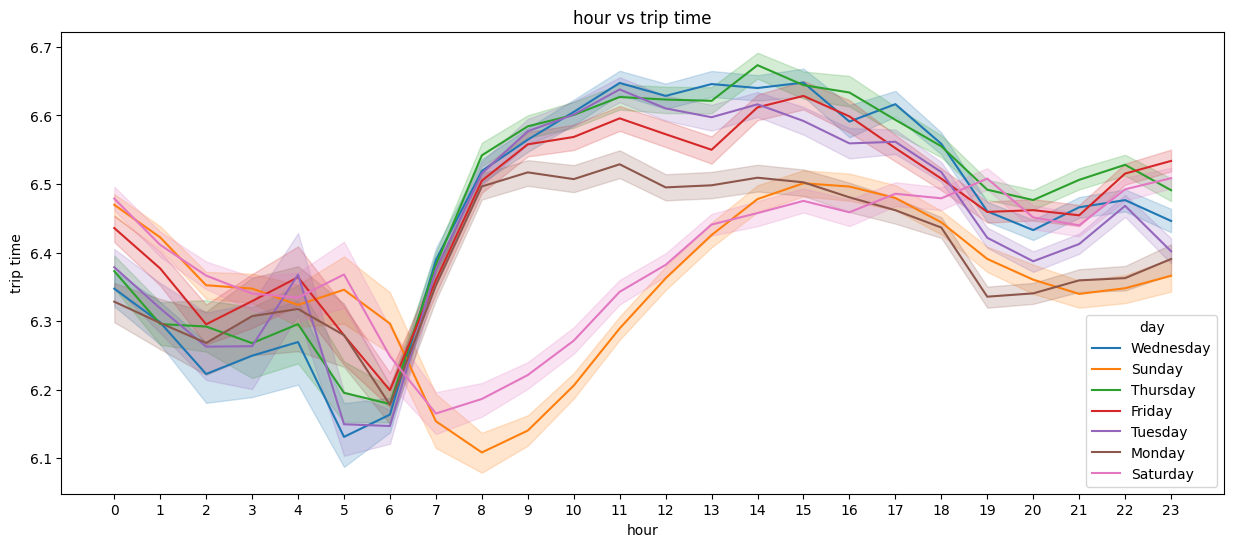

In [37]:
# let's plot the relationship between it with week days
plt.figure(figsize=(15,6)) # to make it more watchable
sns.lineplot(x =df_eda['hour'], y = np.log1p(df_eda['trip_duration'] ), hue = df_eda['day'])
plt.xlabel('hour')
plt.ylabel('trip duration')
hour_ticks = range(0,24)
plt.xticks(hour_ticks)
plt.title('hour vs trip duration')
plt.show()

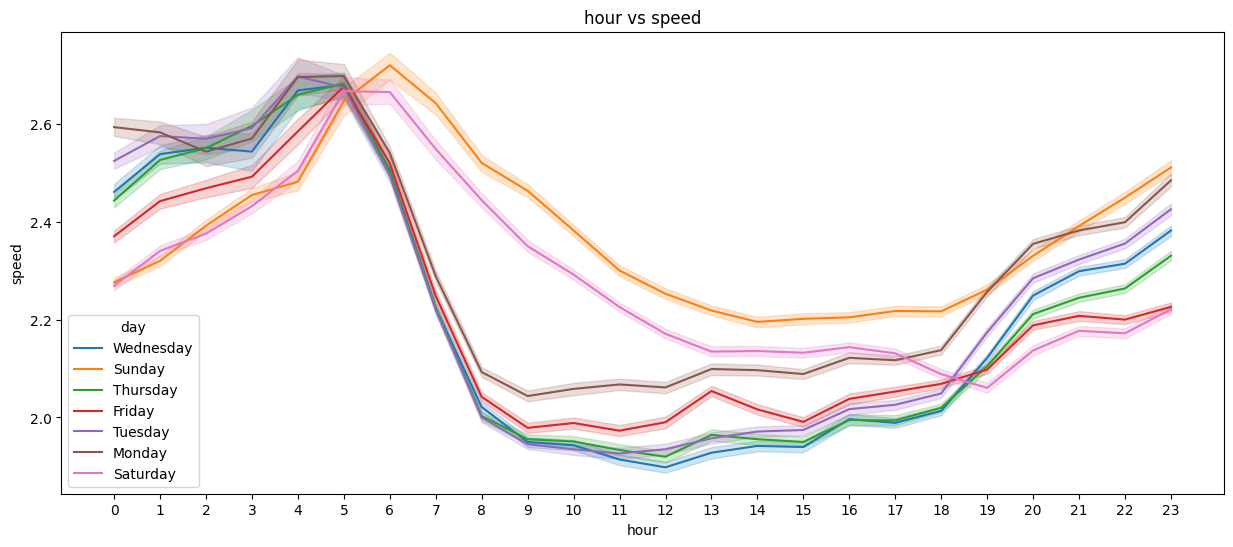

In [38]:
plt.figure(figsize=(15,6)) # to make it more watchable
sns.lineplot(x =df_eda['hour'], y = np.log1p(df_eda['speed_mph'] ), hue = df_eda['day'])
plt.xlabel('hour')
plt.ylabel('speed')
hour_ticks = range(0,24)
plt.xticks(hour_ticks)
plt.title('hour vs speed')
plt.show()

### we see all week work days have a higher trip duration than holidays have less except for a specific hours as speed graph match the duration graph

# Now let's prepare our data and perform model selection 